# Test of the NEB Tm Calculator ([tmcalculator.neb.com](https://tmcalculator.neb.com/#!/batch)) 


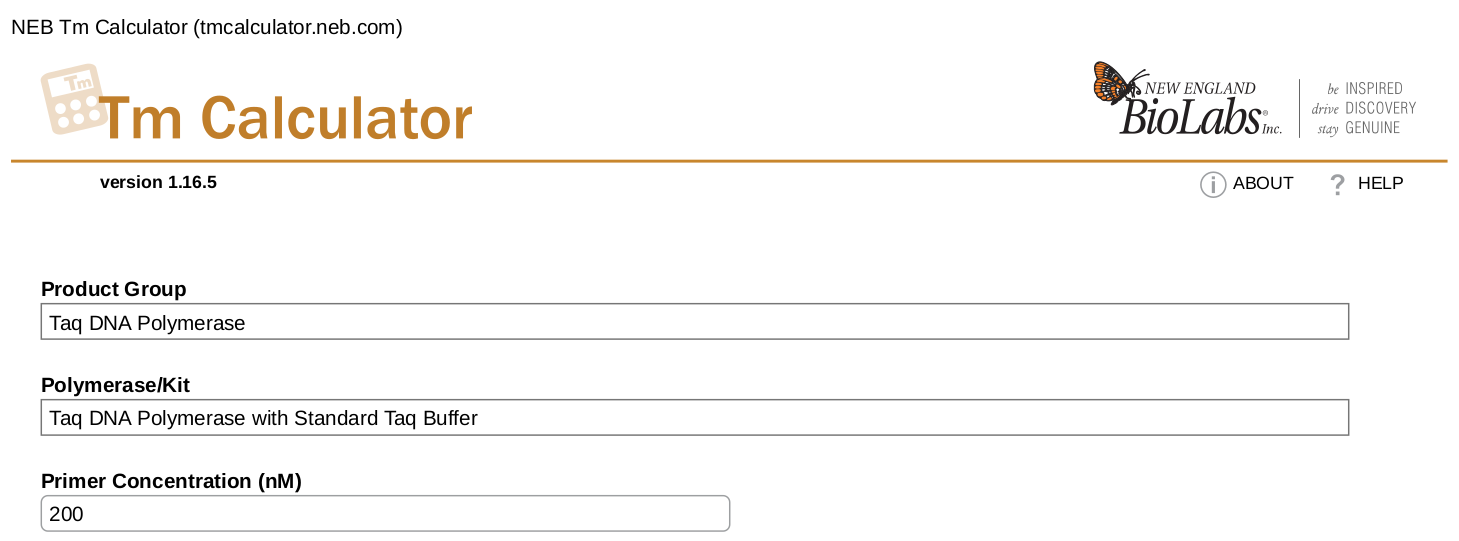.



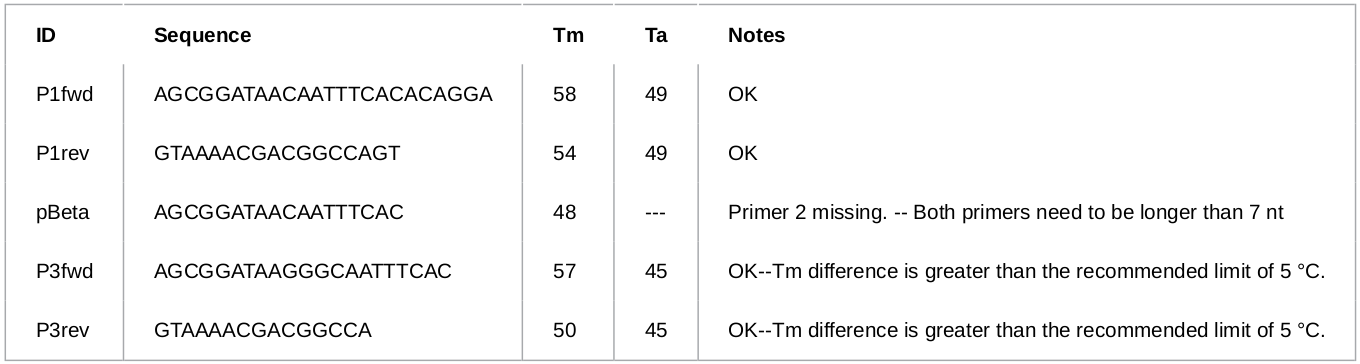.



    example data in text format         Tm (NEB)
    P1fwd	 AGCGGATAACAATTTCACACAGGA   58
    P1rev	 GTAAAACGACGGCCAGT          54
    pBeta	 AGCGGATAACAATTTCAC         48
    P3fwd	 AGCGGATAAGGGCAATTTCAC      57
    P3rev	 GTAAAACGACGGCCA            50



Taq DNA Polymerase with [Standard Taq Buffer](https://www.neb.com/en/products/m0273-taq-dna-polymerase-with-standard-taq-buffer).

    1X Standard Taq Reaction Buffer Pack
    10 mM Tris-HCl
    50 mM KCl
    1.5 mM MgCl2
    (pH 8.3 @ 25°C)

The final concentration of dNTPs is typically 200 μM of each deoxynucleotide [source](https://www.neb.com/en/protocols/0001/01/01/taq-dna-polymerase-with-standard-taq-buffer-m0273).

Thermodynamic data from SantaLucia 1998 and salt correction of Owczarzy 2004 were used according to docs [here](https://tmcalculator.neb.com/#!/help) and [here](https://tmapi.neb.com/#usage).

SantaLucia, J, Jr. “A Unified View of Polymer, Dumbbell, and Oligonucleotide DNA Nearest-Neighbor Thermodynamics.” Proc. Natl. Acad. Sci. U. S. A. 95, no. 4 (February 17, 1998): 1460–65. https://www.ncbi.nlm.nih.gov/pubmed/9465037.

Owczarzy, Richard, Yong You, Bernardo G Moreira, Jeffrey A Manthey, Lingyan Huang, Mark A Behlke, and Joseph A Walder. “Effects of Sodium Ions on DNA Duplex Oligomers: Improved Predictions of Melting Temperatures.” Biochemistry 43, no. 12 (March 30, 2004): 3537–54. https://doi.org/10.1021/bi034621r.

PDFs of there references can be found in the refs folder of this repository.

Can the NEB Tm Calculator be replicated in Biopython? There are four [built in tables](https://biopython.org/docs/1.83/api/Bio.SeqUtils.MeltingTemp.html#Bio.SeqUtils.MeltingTemp.Tm_NN): 

- DNA_NN1: values from Breslauer et al. (1986)
- DNA_NN2: values from Sugimoto et al. (1996)
- DNA_NN3: values from Allawi & SantaLucia (1997) (default)
- DNA_NN4: values from SantaLucia & Hicks (2004)

Biopython does not have the SantaLucia (1998) thermodynamic data. This is similar, but not identical to DNA_NN3 and DNA_NN4 in the table above.

Salt correction from BioPython [docs](https://biopython.org/docs/1.83/api/Bio.SeqUtils.MeltingTemp.html#Bio.SeqUtils.MeltingTemp.salt_correction): 
    
1. 16.6 x log[Na+](Schildkraut & Lifson (1965), Biopolymers 3: 195-208)
2. 16.6 x log([Na+]/(1.0 + 0.7*[Na+]))(Wetmur (1991), Crit Rev Biochem Mol Biol 126: 227-259)
3. 12.5 x log(Na+](SantaLucia et al. (1996), Biochemistry 35: 3555-3562
4. 11.7 x log[Na+](SantaLucia (1998), Proc Natl Acad Sci USA 95: 1460-1465
5. Correction for deltaS: 0.368 x (N-1) x ln[Na+] (SantaLucia (1998), Proc Natl Acad Sci USA 95: 1460-1465)
6. (4.29(%GC)-3.95)x1e-5 x ln[Na+] + 9.40e-6 x ln[Na+]^2  (Owczarzy et al. (2004), Biochemistry 43: 3537-3554) <====<<<<<
7. Complex formula with decision tree and 7 empirical constants. Mg2+ is corrected for dNTPs binding (if present) (Owczarzy et al. (2008), Biochemistry 47: 5336-5353)

The NEB calculator probably uses the #6 Owczarzy et al. (2004).
   

In [39]:
from pydna.parsers import parse_primers

In [58]:
primers = parse_primers("""
>P1fwd NEB Tm Calculator=58
AGCGGATAACAATTTCACACAGGA	
>P1rev NEB Tm Calculator=54
GTAAAACGACGGCCAGT	       
>pBeta NEB Tm Calculator=48
AGCGGATAACAATTTCAC
>P3fwd NEB Tm Calculator=57
AGCGGATAAGGGCAATTTCAC	    
>P3rev NEB Tm Calculator=50
GTAAAACGACGGCCA	        
""")

In [59]:
from Bio.SeqUtils import MeltingTemp as mt

In [60]:
# SantaLucia (1998) 
DNA_NN5 = {
    "init": (0, 0), "init_A/T": (2.3, 4.1), "init_G/C": (0.1, -2.8),
    "init_oneG/C": (0, 0), "init_allA/T": (0, 0), "init_5T/A": (0, 0),
    "sym": (0, -1.4),
    "AA/TT": (-7.9, -22.2), "AT/TA": (-7.2, -20.4), "TA/AT": (-7.2, -21.3),
    "CA/GT": (-8.5, -22.7), "GT/CA": (-8.4, -22.4), "CT/GA": (-7.8, -21.0),
    "GA/CT": (-8.2, -22.2), "CG/GC": (-10.6, -27.2), "GC/CG": (-9.8, -24.4),
    "GG/CC": (-8.0, -19.9)}

In [61]:
table_dict = {
"Breslauer 1986 " :mt.DNA_NN1, 
"Sugimoto 1996" :mt.DNA_NN2, 
"Allawi and SantaLucia 1997" :mt.DNA_NN3, 
"SantaLucia & Hicks 2004" :mt.DNA_NN4,
"SantaLucia 1998" :DNA_NN5,
}

In [62]:
saltcorr_dict = { "Schildkraut 1965":1,
                  "Wetmur 1991":2,
                  "SantaLucia 1996":3,
                  "SantaLucia 1998":4,
                  "SantaLucia 1998 dS":5,
                  "Owczarzy 2004":6,
                  "Owczarzy 2008":7, }

In [63]:
nn_table = table_dict["SantaLucia 1998"]
saltcorr = saltcorr_dict["Owczarzy 2004"]

for p in primers:
    
    print(p.description, "biopython = ", mt.Tm_NN(str(p.seq), 
                   nn_table=nn_table,
                   Na=50,         # mM
                   Tris=10,       # mM
                   Mg=1.5,        # mM
                   dnac1=200,     # nM
                   dnac2=0,       # nM
                   dNTPs=200*4,     # mM
                   saltcorr=saltcorr))

P1fwd NEB Tm Calculator=58 biopython =  57.614086700105645
P1rev NEB Tm Calculator=54 biopython =  53.96469180796623
pBeta NEB Tm Calculator=48 biopython =  47.95215317414028
P3fwd NEB Tm Calculator=57 biopython =  56.948297500718695
P3rev NEB Tm Calculator=50 biopython =  50.361977364511176


Now, lets try Q5

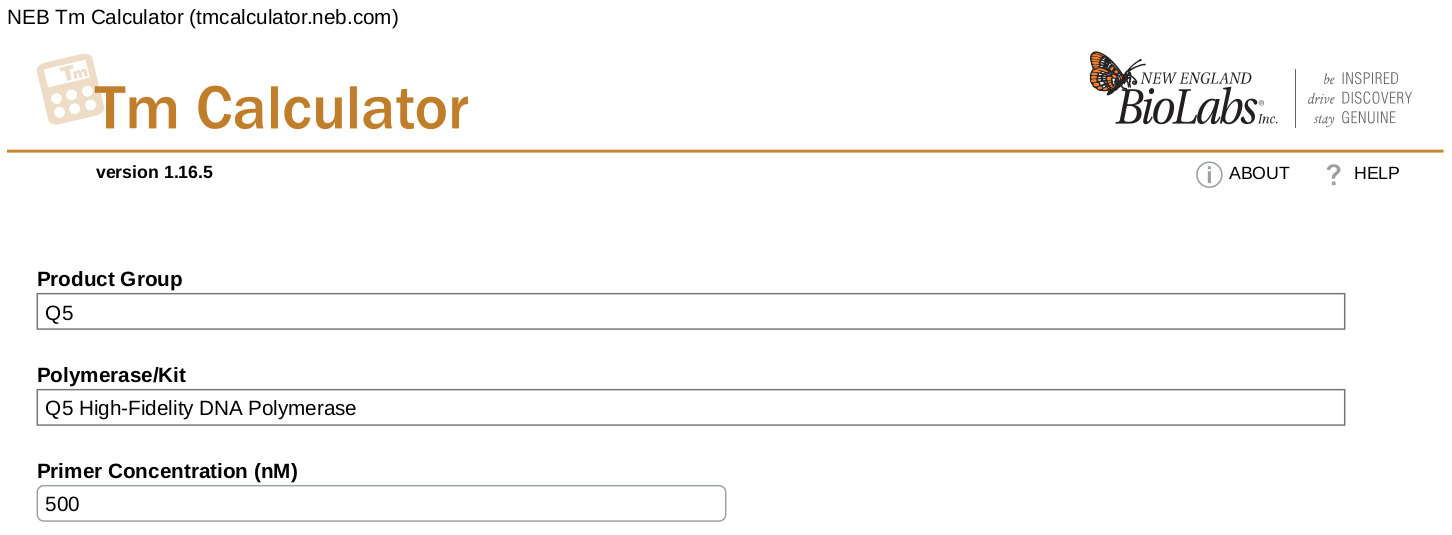


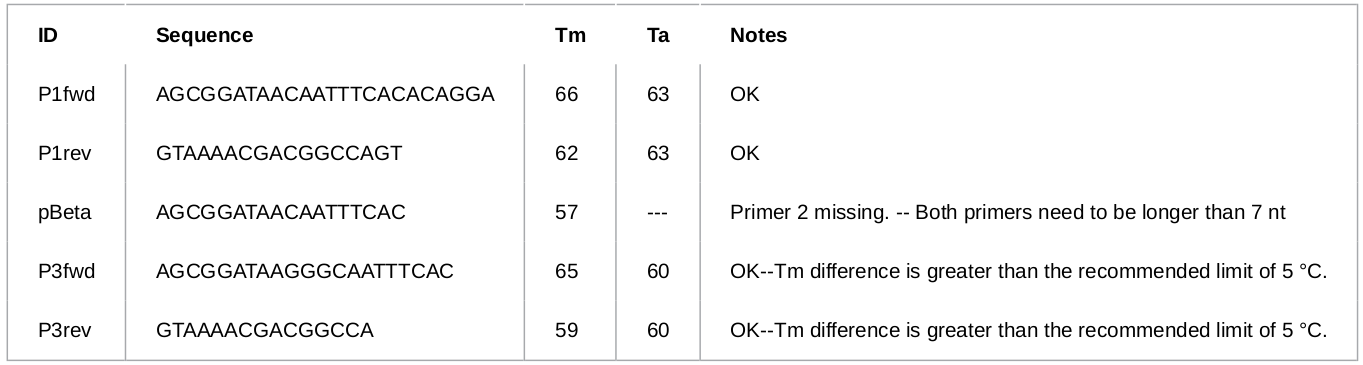


 
    example data in text format         Tm (NEB)
    P1fwd	 AGCGGATAACAATTTCACACAGGA   66	
    P1rev	 GTAAAACGACGGCCAGT          62	
    pBeta	 AGCGGATAACAATTTCAC         57	
    P3fwd	 AGCGGATAAGGGCAATTTCAC      65	
    P3rev	 GTAAAACGACGGCCA            59


The final concentration of dNTPs is typically 200 μM of each deoxynucleotide [source](https://www.neb.com/en/protocols/2012/08/30/pcr-using-q5-hot-start-high-fidelity-dna-polymerase-m0493)
    

In [64]:
primers = parse_primers("""
>P1fwd NEB Tm Calculator=66
AGCGGATAACAATTTCACACAGGA	
>P1rev NEB Tm Calculator=62
GTAAAACGACGGCCAGT	       
>pBeta NEB Tm Calculator=57
AGCGGATAACAATTTCAC
>P3fwd NEB Tm Calculator=65
AGCGGATAAGGGCAATTTCAC	    
>P3rev NEB Tm Calculator=59
GTAAAACGACGGCCA	        
""")

In [71]:
nn_table = table_dict["SantaLucia 1998"]
saltcorr = saltcorr_dict["Owczarzy 2004"]

for p in primers:    
    print(p.description, "biopython = ", mt.Tm_NN(str(p.seq), 
                   nn_table=nn_table,
                   Na=150,        # mM  Unknown!
                   Tris=20,       # mM  Unknown!
                   Mg=2.0,        # mM
                   dnac1=500,     # nM
                   dnac2=0,       # nM
                   dNTPs=200*4,   # mM
                   saltcorr=saltcorr))

P1fwd NEB Tm Calculator=66 biopython =  66.65909571708926
P1rev NEB Tm Calculator=62 biopython =  62.64940520464643
pBeta NEB Tm Calculator=57 biopython =  56.97773805022064
P3fwd NEB Tm Calculator=65 biopython =  65.79675325562664
P3rev NEB Tm Calculator=59 biopython =  59.04154521554523


In [87]:
nn_table = table_dict["SantaLucia 1998"]
saltcorr = saltcorr_dict["Schildkraut 1965"]

for p in primers:    
    print(p.description, "biopython = ", mt.Tm_NN(str(p.seq), 
                   nn_table=nn_table,
                   Na=300,        # mM  Unknown!
                   Tris=0,        # mM  Unknown!
                   Mg=2.0,        # mM
                   dnac1=500,     # nM
                   dnac2=0,       # nM
                   dNTPs=200*4,   # mM
                   saltcorr=saltcorr))

P1fwd NEB Tm Calculator=66 biopython =  66.40440482003825
P1rev NEB Tm Calculator=62 biopython =  61.14878923694269
pBeta NEB Tm Calculator=57 biopython =  56.493983772088
P3fwd NEB Tm Calculator=65 biopython =  64.93520712660413
P3rev NEB Tm Calculator=59 biopython =  57.35040507304305
